# Nonlinear solvers
This is a large-scale nonlinear multidimensional solver. It finds $x$ for which $F(x)=0$, using Krylov approximation for inverse Jacobian. Both $x$ and $F$ can be multidimensional.
## Root finding for large problems
Suppose that we needed to solve the following integrodifferential equation on the square $[0,1]\times[0,1]$:
$$
\left(\partial_x^2+\partial_y^2 \right) P + 5\left(\int^1_0\int^1_0\mathrm{cosh}(P)dx dy\right)^2=0
$$
with the boundary condition $P(x,1)=1$ on the upper edge and and $P=0$ elsewhere on the boundary of the square. This can be done by approximating the continuous function $P$ by its values on a grid, $P_{n,m}\approx P(nh,mh)$, with a small grid spacing $h$. The derivatives and integral can then be approximated; for instance 
$$
\partial_x^2 P(x,y) \approx \frac{P(x+h,y)-2P(x,y)+P(x-h,y)}{h^2}.
$$
The problem is then equivalent to finding the root of some function $\texttt{residual(P)}$, where $\texttt{P}$ is a vector of length $N_x N_y$. 
The solution can be found using the [newton_krylov](http://jiffyclub.github.io/scipy/generated/scipy.optimize.newton_krylov.html#scipy.optimize.newton_krylov) solver:

In [1]:
import numpy as np
from scipy.optimize import newton_krylov, root
from numpy import cosh, zeros_like, mgrid, zeros, eye

# parameters
nx, ny = 75, 75
hx, hy = 1./(nx-1), 1./(ny-1)

P_left, P_right = 0, 0
P_top, P_bottom = 1, 0

def residual(P):
    d2x = zeros_like(P)
    d2y = zeros_like(P)

    d2x[1:-1] = (P[2:]   - 2*P[1:-1] + P[:-2]) / hx/hx
    d2x[0]    = (P[1]    - 2*P[0]    + P_left)/hx/hx
    d2x[-1]   = (P_right - 2*P[-1]   + P[-2])/hx/hx

    d2y[:,1:-1] = (P[:,2:] - 2*P[:,1:-1] + P[:,:-2])/hy/hy
    d2y[:,0]    = (P[:,1]  - 2*P[:,0]    + P_bottom)/hy/hy
    d2y[:,-1]   = (P_top   - 2*P[:,-1]   + P[:,-2])/hy/hy

    return d2x + d2y + 5*cosh(P).mean()**2


In [2]:
# solve
guess = zeros((nx, ny), float)
sol = newton_krylov(residual, guess, method='gmres', verbose=1)
print('Residual: %g' % abs(residual(sol)).max())

0:  |F(x)| = 75.2443; step 1
1:  |F(x)| = 23.0366; step 1
2:  |F(x)| = 13.8722; step 1
3:  |F(x)| = 9.71018; step 1
4:  |F(x)| = 7.46537; step 1
5:  |F(x)| = 5.0889; step 1
6:  |F(x)| = 4.27331; step 1
7:  |F(x)| = 3.02498; step 1
8:  |F(x)| = 2.51137; step 1
9:  |F(x)| = 1.84834; step 1
10:  |F(x)| = 1.55923; step 1
11:  |F(x)| = 1.14455; step 1
12:  |F(x)| = 0.978506; step 1
13:  |F(x)| = 0.714267; step 1
14:  |F(x)| = 0.616282; step 1
15:  |F(x)| = 0.447724; step 1
16:  |F(x)| = 0.388935; step 1
17:  |F(x)| = 0.281375; step 1
18:  |F(x)| = 0.245671; step 1
19:  |F(x)| = 0.177115; step 1
20:  |F(x)| = 0.155239; step 1
21:  |F(x)| = 0.111601; step 1
22:  |F(x)| = 0.0981002; step 1
23:  |F(x)| = 0.0703571; step 1
24:  |F(x)| = 0.0619869; step 1
25:  |F(x)| = 0.0443711; step 1
26:  |F(x)| = 0.0391644; step 1
27:  |F(x)| = 0.027991; step 1
28:  |F(x)| = 0.0247407; step 1
29:  |F(x)| = 0.0176599; step 1
30:  |F(x)| = 0.0156475; step 1
31:  |F(x)| = 0.0111452; step 1
32:  |F(x)| = 0.009897

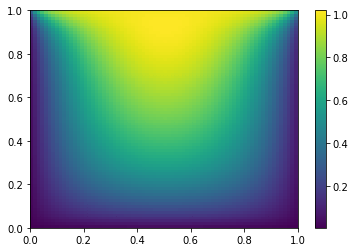

In [3]:
# visualize
import matplotlib.pyplot as plt
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

## Preconditioning
When looking for the zero of the function $f_i(\mathbf{x})=0$, $i=1,2,\ldots,N$ the solver spends most of its time inverting the Jacobian matrix
$$
\mathbf{J}_{i,j}=\frac{\partial f_i}{\partial x_j}.
$$
If you have an approximation for the inverse matrix $\mathbf{M}\approx \mathbf{J}^{-1}$,  you can use it for _preconditioning_ the linear-inversion problem. The idea is that instead of solving $\mathbf{J}\mathbf{s}=\mathbf{y}$ you solve $\mathbf{M}\mathbf{J}\mathbf{s}=\mathbf{M}\mathbf{y}$. Since $\mathbf{M}\mathbf{J}\approx \mathbf{I}$ is "closer" to the identity matrix than $\mathbf{J}$ is, the equation should be easier for the Krylov method to deal with. 

The Jacobian corresponding to the Laplace operator part of the function (denoted $\mathbf{J}_1$) can be computed easily. We know that in 1-D:
$$
\partial_x^2\approx
\frac{1}{h^2_x}
\begin{bmatrix}
-2 & 1 & 0 & 0 &\cdots\\
 1 &-2 & 1 & 0 &\cdots\\
 0 & 1 &-2 & 1 &\cdots\\
\vdots & & &\ddots & 
\end{bmatrix}=h_x^{-2}\mathbf{L}
$$
so the whole 2-D operator is then
$$
\mathbf{J}_1 = \partial_x^2 + \partial_y^2\approx h_x^{-2}\mathbf{L}\otimes\mathbf{I} + h_y^{-2}\mathbf{I}\otimes\mathbf{L}.
$$
The matrix $\mathbf{J}_2$ of the Jacobian corresponding to the integral is more difficult to calculate, and since _all_ of its entries are nonzero, it will be difficult to invert. Since $\mathbf{J}_1$ is easy to invert, we'll take $\mathbf{M}\approx \mathbf{J}^{-1}_1$ and hope for the best.

In [7]:
from scipy.sparse import spdiags, kron, csc_matrix
from scipy.sparse.linalg import spilu, LinearOperator

def get_preconditioner():
    """Compute the preconditioner M"""
    diags_x = zeros((3, nx))
    diags_x[0,:] = 1/hx/hx
    diags_x[1,:] = -2/hx/hx
    diags_x[2,:] = 1/hx/hx
    Lx = spdiags(diags_x, [-1,0,1], nx, nx)

    diags_y = zeros((3, ny))
    diags_y[0,:] = 1/hy/hy
    diags_y[1,:] = -2/hy/hy
    diags_y[2,:] = 1/hy/hy
    Ly = spdiags(diags_y, [-1,0,1], ny, ny)

    J1 = kron(Lx, eye(ny)) + kron(eye(nx), Ly)
    J1 = csc_matrix(J1) # convert to sparse format to use spilu

    # Now we have the matrix `J_1`. We need to find its inverse `M` --
    # however, since an approximate inverse is enough, we can use
    # the *incomplete LU* decomposition

    J1_ilu = spilu(J1)

    # This returns an object with a method .solve() that evaluates
    # the corresponding matrix-vector product. We need to wrap it into
    # a LinearOperator before it can be passed to the Krylov methods:

    M = LinearOperator(shape=(nx*ny, nx*ny), matvec=J1_ilu.solve)
    return M

In [8]:
M = get_preconditioner()
sol = newton_krylov(residual, guess, method='gmres', inner_M=M, verbose=1)
print('Residual: %g' % abs(residual(sol)).max())

0:  |F(x)| = 58.5587; step 1
1:  |F(x)| = 7.15202; step 1
2:  |F(x)| = 0.622405; step 1
3:  |F(x)| = 0.00627306; step 1
4:  |F(x)| = 0.000341975; step 1
5:  |F(x)| = 4.24218e-06; step 1
Residual: 4.24218e-06


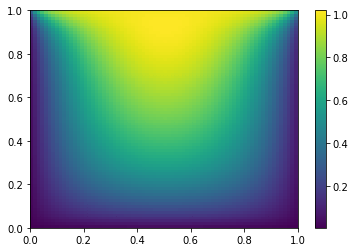

In [6]:
# visualize
import matplotlib.pyplot as plt
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()